cid : 리뷰를 작성한 리뷰어의 ID

rScore : 리뷰의 평점

pID : 리뷰가 달린 상품의 ID

desc : 리뷰의 내용

rDate: 리뷰가 작성된 날짜

rNo : 리뷰번호

In [23]:
go_data.columns

Index([u'_id', u'bodySize', u'cId', u'desc', u'height', u'helpful', u'pColor',
       u'pID', u'pSize', u'pTitle', u'pURL', u'rDate', u'rImages', u'rNo',
       u'rScore', u'weight'],
      dtype='object')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import statistics

from konlpy.tag import Twitter
from konlpy.utils import pprint
from collections import Counter
twitter = Twitter()

In [3]:
# 1.
#reviewer의 desc를 담는 리스트
def make_reviews(cid):
    reviews=(go_data.loc[go_data['cId']==cid])['desc']
    reviews=list(reviews)
    
    return reviews

#1-1 
    
# 2.
# review의 morphs를 담는 리스트
def make_morphs(reviews):
    
    t=Twitter()
    review_morphs=[]

    for i in range(len(reviews)):
        review_morphs.append(t.morphs(reviews[i]))
        
    morphs=[y for x in review_morphs for y in x]  #2중 list를 flatten하게 만듦
    review_morphs= list(set(morphs))
    
    return review_morphs

# 3.
# term-frequency 함수
def counting(reviews, review_morphs):
   
    tmp = dict()
    for i in range(len(review_morphs)):
        tmp[review_morphs[i]] = reviews.count(review_morphs[i])
    return tmp  


#review_list = review들(desc)을 모두 담은 list
# term-frequency로 벡터화한 리뷰들을 담은 리스트를 만드는 함수

def term_fre(reviews):
    review_morphs=make_morphs(reviews)
    review_vec_list=[]
    for i in range(len(reviews)):  
        review_vec_list.append(counting(reviews[i],review_morphs))
    
    return review_vec_list

# 4. 만든 term-frequency를 table로 만들어 보기 쉽게하기
def make_table(reviews):
    vectors=term_fre(reviews)
    table=pd.DataFrame(vectors)
    return table

# 5. 4에서 만든 table의 행(vector들)을 하나의 리스트에 담기 -> 각 리뷰의 벡터값들만 모은 리스트
def table_to_review_vector(reviews):
    table=make_table(reviews)
    table_ix=table.index
    review_vectors=[]
    for i in range(len(table_ix)):
        review_vectors.append(table.loc[table_ix[i]])
    return review_vectors

 # 소수점 아래 3자리까지 나타내기, 4째자리에서 반올림
def short_float(val):
    value = float("{:.3f}".format(val))
    return value

#cosine similarity 함수
def similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

#nCr 함수
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

In [4]:
# 6. 리뷰의 유사도 구하기
def review_similarity(review_vectors):
    over_count=0
    min=0
    max=0
    avg=0
    sum=0 #모든 유사도의 합
    sm=[] #similarity를 담을 리스트
    cnt=0 # 유사도가 1인 개수
    li=review_vectors
    for i in range(len(li)-1):
        for j in range(i+1,len(li)):
            #print(i+1),;print(u'번째 리뷰와'),;print(j+1),;print(u'번째 리뷰 : '),;  print(similarity(li[i],li[j])); #유사도 구하기
            val=short_float(similarity(li[i],li[j])) # 구한 유사도를 소수점 아래 3째자리까지 나타내기
            sm.append(val)
            if(val==1.0):
                cnt+=1
            
    if(len(sm)>1):  # 리뷰를 3개이상 작성시
        sum=sm[0]
        min=sm[0]
        max=sm[0]
        for i in range(1,len(sm)):
            sum+=sm[i]
            if(min>sm[i]):
                min=sm[i]
            if(max<sm[i]):
                max=sm[i]
            if(sm[i]>=0.8):
                over_count+=1
                
                
    else: # 리뷰를 2개만 작성시
        sum=sm[0]
        min=sm[0]
        max=sm[0]
        if(sm[0]>=0.8):
                over_count+=1

    avg = short_float(sum/len(sm))

    #print('similarity: ', sm)
    print ('min', min)
    print ('max', max)
    print('num of similarity=0.8 over : ', over_count)
    print('avg', avg)
    print('# of similarity=1 ', cnt)
    print('ratio of similarity=1: ', short_float((1.0*cnt/nCr(len(li),2))*100))
    
    return over_count
       


In [6]:
len(go_data) # 리뷰의 크기, 총 약 77만개의 리뷰 존재

772829

In [11]:
len(cid) # 리뷰어들의 수, 총 약 13만명의 리뷰어 존재

138650

In [13]:
df=go_data['rScore'].value_counts()
df

5.0    700708
4.0     46769
3.0     18178
2.0      4563
1.0      2611
Name: rScore, dtype: int64

In [14]:
len(go_data)

772829

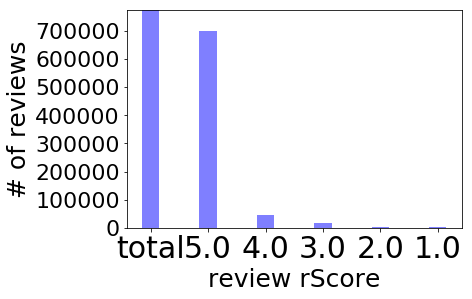

ratio 5.0: 90.668
ratio 4.0 : 6.052
ratio 3.0: 2.352
ratio 2.0 : 0.59
ratio 1.0 : 0.338


In [15]:
score = ('total', '5.0', '4.0', '3.0', '2.0', '1.0')
total=772829
score5= 700708
score4=46769
score3= 18178
score2= 4563
score1=2611
number_of_reviews = [total,
                     score5,
                     score4,
                     score3,
                     score2,
                     score1]

plt.bar(score, number_of_reviews, color=['blue'],
        width=0.3, alpha=0.5)
plt.xticks(score, fontsize=30)
plt.yticks(fontsize=22)
plt.ylabel('# of reviews', fontsize=25)
plt.rcParams["figure.figsize"] = (8,6)
plt.xlabel('review rScore', fontsize=25)
ax = plt.gca()
ax.set_ylim([0.0, 772829])
plt.show()


print ("ratio 5.0: " + str(short_float(1.0*(score5)*100/total)))
print ("ratio 4.0 : " + str(short_float(1.0*(score4)*100/total)))
print ("ratio 3.0: " + str(short_float(1.0*(score3)*100/total)))
print ("ratio 2.0 : " + str(short_float(1.0*(score2)*100/total)))
print ("ratio 1.0 : " + str(short_float(1.0*(score1)*100/total)))


In [ ]:
spammer=[]
one_reviewer=[]
for i in range(len(cid)):
    print(i+1),;print(u'번째 리뷰어');
    reviews=make_reviews(cid[i])
    make_morphs(reviews)
    term_fre(reviews)
    make_table(reviews)
    vectors=table_to_review_vector(reviews)
    if(len(reviews)>=2):
        over_cnt=review_similarity(vectors)
    else:
        print('one reviewer')
        one_reviewer.append(cid[i])
        over_cnt=0
    
    if(over_cnt>=1): # 리뷰 유사도가 0.8 이상인 것의 개수
        spammer.append(cid[i])